In [1]:
!pip3 install scipy
!pip3 install glob2

import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import PIL.Image as Image
import glob

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
config = tf.compat.v1.ConfigProto(allow_soft_placement=True)

config.gpu_options.per_process_gpu_memory_fraction = 0.3
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

     |████████████████████████████████| 25.9 MB 12.2 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
  Created wheel for glob2: filename=glob2-0.7-py2.py3-none-any.whl size=9307 sha256=5d0cab7a2b29dba8267319698da501735fcea374c293e68c68a22476a7b60715
  Stored in directory: /root/.cache/pip/wheels/96/2f/ad/5bba2807c8e762a019e4abd6f70dafbab1889acda23192aeff
Successfully built glob2
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Num GPUs Available:  1


In [2]:
# pre-process, structure: labels array [ID, val]
# check if dir structure exists

tpath = './data/train'

if os.path.exists(tpath + '/0') == True or os.path.exists(tpath + '/1') == True:
    print ("Directory exist!")
else:
    os.mkdir(tpath+"/0")
    os.mkdir(tpath+"/1")
    print ("Train structure created")
    
#populate directories
labels = np.loadtxt('./train.csv',delimiter=",",dtype=np.str,skiprows=1)

# skipp if not empty
if not (os.listdir(tpath + '/0') or os.listdir(tpath + '/1')):
    print ("Copy started...")
    for fn,val in labels:

        # select path to copy files
        if val == str(1):
            os.popen('cp '+ tpath + '/'+ fn + ' ' +tpath+'/1') 
        else:
            os.popen('cp '+ tpath + '/'+ fn + ' ' +tpath+'/0')
    print ("Files are copied!")
else:
    print ("Directories are not empty!")



Directory exist!
Directories are not empty!


In [3]:
# input image size 32x32
size = 32
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                             rotation_range=40,
                                                             width_shift_range=0.2,
                                                             height_shift_range=0.2,
                                                             shear_range=0.2,
                                                             zoom_range=0.2,
                                                             horizontal_flip=True,
                                                             validation_split=0.2
                                                            )


train_generator = train_datagen.flow_from_directory('./data/train',target_size=(size,size),
                                                    batch_size=64,
                                                    #classes=['train'],
                                                    class_mode='binary',
                                                    subset='training',
                                                    color_mode='rgb',
                                                    shuffle=True)

val_generator = train_datagen.flow_from_directory('./data/train',
                                                    target_size=(size,size),
                                                    #classes=['train'],
                                                    batch_size=64, 
                                                    class_mode='binary',
                                                    subset='validation',
                                                    color_mode='rgb',
                                                    shuffle=True)


test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory('./data/', 
                                                    target_size=(size,size), 
                                                    batch_size=32, 
                                                    classes=['test'],
                                                    class_mode='binary',
                                                    shuffle=False)


Found 14001 images belonging to 2 classes.
Found 3499 images belonging to 2 classes.
Found 4000 images belonging to 1 classes.


In [4]:
# create a sequencial model

model = keras.models.Sequential()

model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(size,size,3)))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D(2, 2))


model.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D(2, 2))



model.add(keras.layers.Flatten())

# reduce overfitting
model.add(keras.layers.Dropout(0.3))

model.add(keras.layers.Dense(512, activation='relu'))


# out layer [0,1] => sigmoid activation
model.add(keras.layers.Dense(1, activation='sigmoid'))


model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.0001), loss='binary_crossentropy', metrics=['acc'])


In [5]:
steps=50
valsteps=8
epoches=200

hist = model.fit(x=train_generator, validation_data=val_generator, epochs=20,verbose=2)


Epoch 1/20
219/219 - 22s - loss: 0.3855 - acc: 0.8286 - val_loss: 0.2583 - val_acc: 0.9125
Epoch 2/20
219/219 - 13s - loss: 0.2368 - acc: 0.9156 - val_loss: 0.2418 - val_acc: 0.9185
Epoch 3/20
219/219 - 12s - loss: 0.2252 - acc: 0.9152 - val_loss: 0.2126 - val_acc: 0.9266
Epoch 4/20
219/219 - 13s - loss: 0.2104 - acc: 0.9203 - val_loss: 0.2067 - val_acc: 0.9237
Epoch 5/20
219/219 - 12s - loss: 0.2053 - acc: 0.9231 - val_loss: 0.1965 - val_acc: 0.9291
Epoch 6/20
219/219 - 12s - loss: 0.1947 - acc: 0.9262 - val_loss: 0.1866 - val_acc: 0.9374
Epoch 7/20
219/219 - 12s - loss: 0.1894 - acc: 0.9283 - val_loss: 0.1827 - val_acc: 0.9323
Epoch 8/20
219/219 - 12s - loss: 0.1825 - acc: 0.9293 - val_loss: 0.2151 - val_acc: 0.9220
Epoch 9/20
219/219 - 13s - loss: 0.1752 - acc: 0.9345 - val_loss: 0.1974 - val_acc: 0.9291
Epoch 10/20
219/219 - 13s - loss: 0.1708 - acc: 0.9347 - val_loss: 0.1606 - val_acc: 0.9423
Epoch 11/20
219/219 - 12s - loss: 0.1624 - acc: 0.9393 - val_loss: 0.1727 - val_acc: 0.93

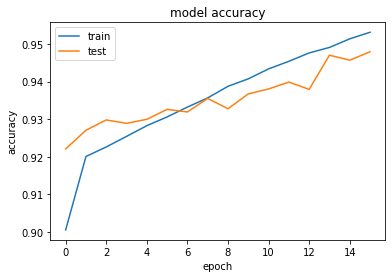

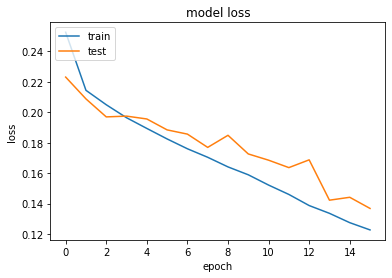

In [6]:
win = 5
def mavr(data, win):
    return np.convolve(data, np.ones(win), 'valid') / win

plt.plot(mavr(hist.history['acc'],win))
plt.plot(mavr(hist.history['val_acc'],win))
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(mavr(hist.history['loss'],win))
plt.plot(mavr(hist.history['val_loss'],win))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [7]:
model.save('k_cactus.h5')

In [42]:
# make inference and generate submission file

Y_pred = model.predict(x=test_generator, steps=len(test_generator))
Y_pred = np.round(Y_pred,0)

tdir = "./data/test/*.jpg"
imgn = np.array([[os.path.basename(k) for k in glob.glob(tdir, recursive=True)]])

# write data to file
wdata= np.hstack((imgn.T,Y_pred))
np.savetxt('submission.csv',wdata,fmt=['%s', '%s'],delimiter=',', header='id,has_cactus',comments='')